<a href="https://colab.research.google.com/github/miranda-bi/CHL5230-Datathon/blob/main/Datathon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')

# Part 1: Factors that affect likelihood of getting heart disease

In [ ]:
from google.colab import files
uploaded = files.upload()

# Import necessary libraries
import pandas as pd
import io

# Read the dataset into a Pandas DataFrame
#df = pd.read_csv('Cardiovascular Event Dataset.csv')
df = pd.read_csv(io.BytesIO(uploaded['Cardiovascular Event Dataset.csv']))


# Inspect the first five rows of the data
df.head()

Saving Cardiovascular Event Dataset.csv to Cardiovascular Event Dataset.csv


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
#Move heart disease column to end
df.insert(len(df.columns)-1, 'heart_disease', df.pop('heart_disease'))

df.head()

,id,gender,age,hypertension,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,heart_disease
0,9046,Male,67.0,0,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1
1,51676,Female,61.0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,0
2,31112,Male,80.0,0,Yes,Private,Rural,105.92,32.5,never smoked,1,1
3,60182,Female,49.0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0
4,1665,Female,79.0,1,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0


In [ ]:
# Count of heart disease outcome - limitation in that there was bias in data
print((df['heart_disease']==0).sum())
print((df['heart_disease']==1).sum())

4834
276


In [ ]:
# Check for missing values in each column
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
heart_disease          0
dtype: int64


In [ ]:
#Fill in nan values with the median
df.fillna(df.median(), inplace=True)

In [ ]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # Female: 0, Male: 1, Other: 2
df['ever_married'] = le.fit_transform(df['ever_married'])
df['work_type'] = le.fit_transform(df['work_type'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

df.head()

,id,gender,age,hypertension,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,heart_disease
0,9046,1,67.0,0,1,2,1,228.69,36.6,1,1,1
1,51676,0,61.0,0,1,3,0,202.21,28.1,2,1,0
2,31112,1,80.0,0,1,2,0,105.92,32.5,2,1,1
3,60182,0,49.0,0,1,2,1,171.23,34.4,3,1,0
4,1665,0,79.0,1,1,3,0,174.12,24.0,2,1,0


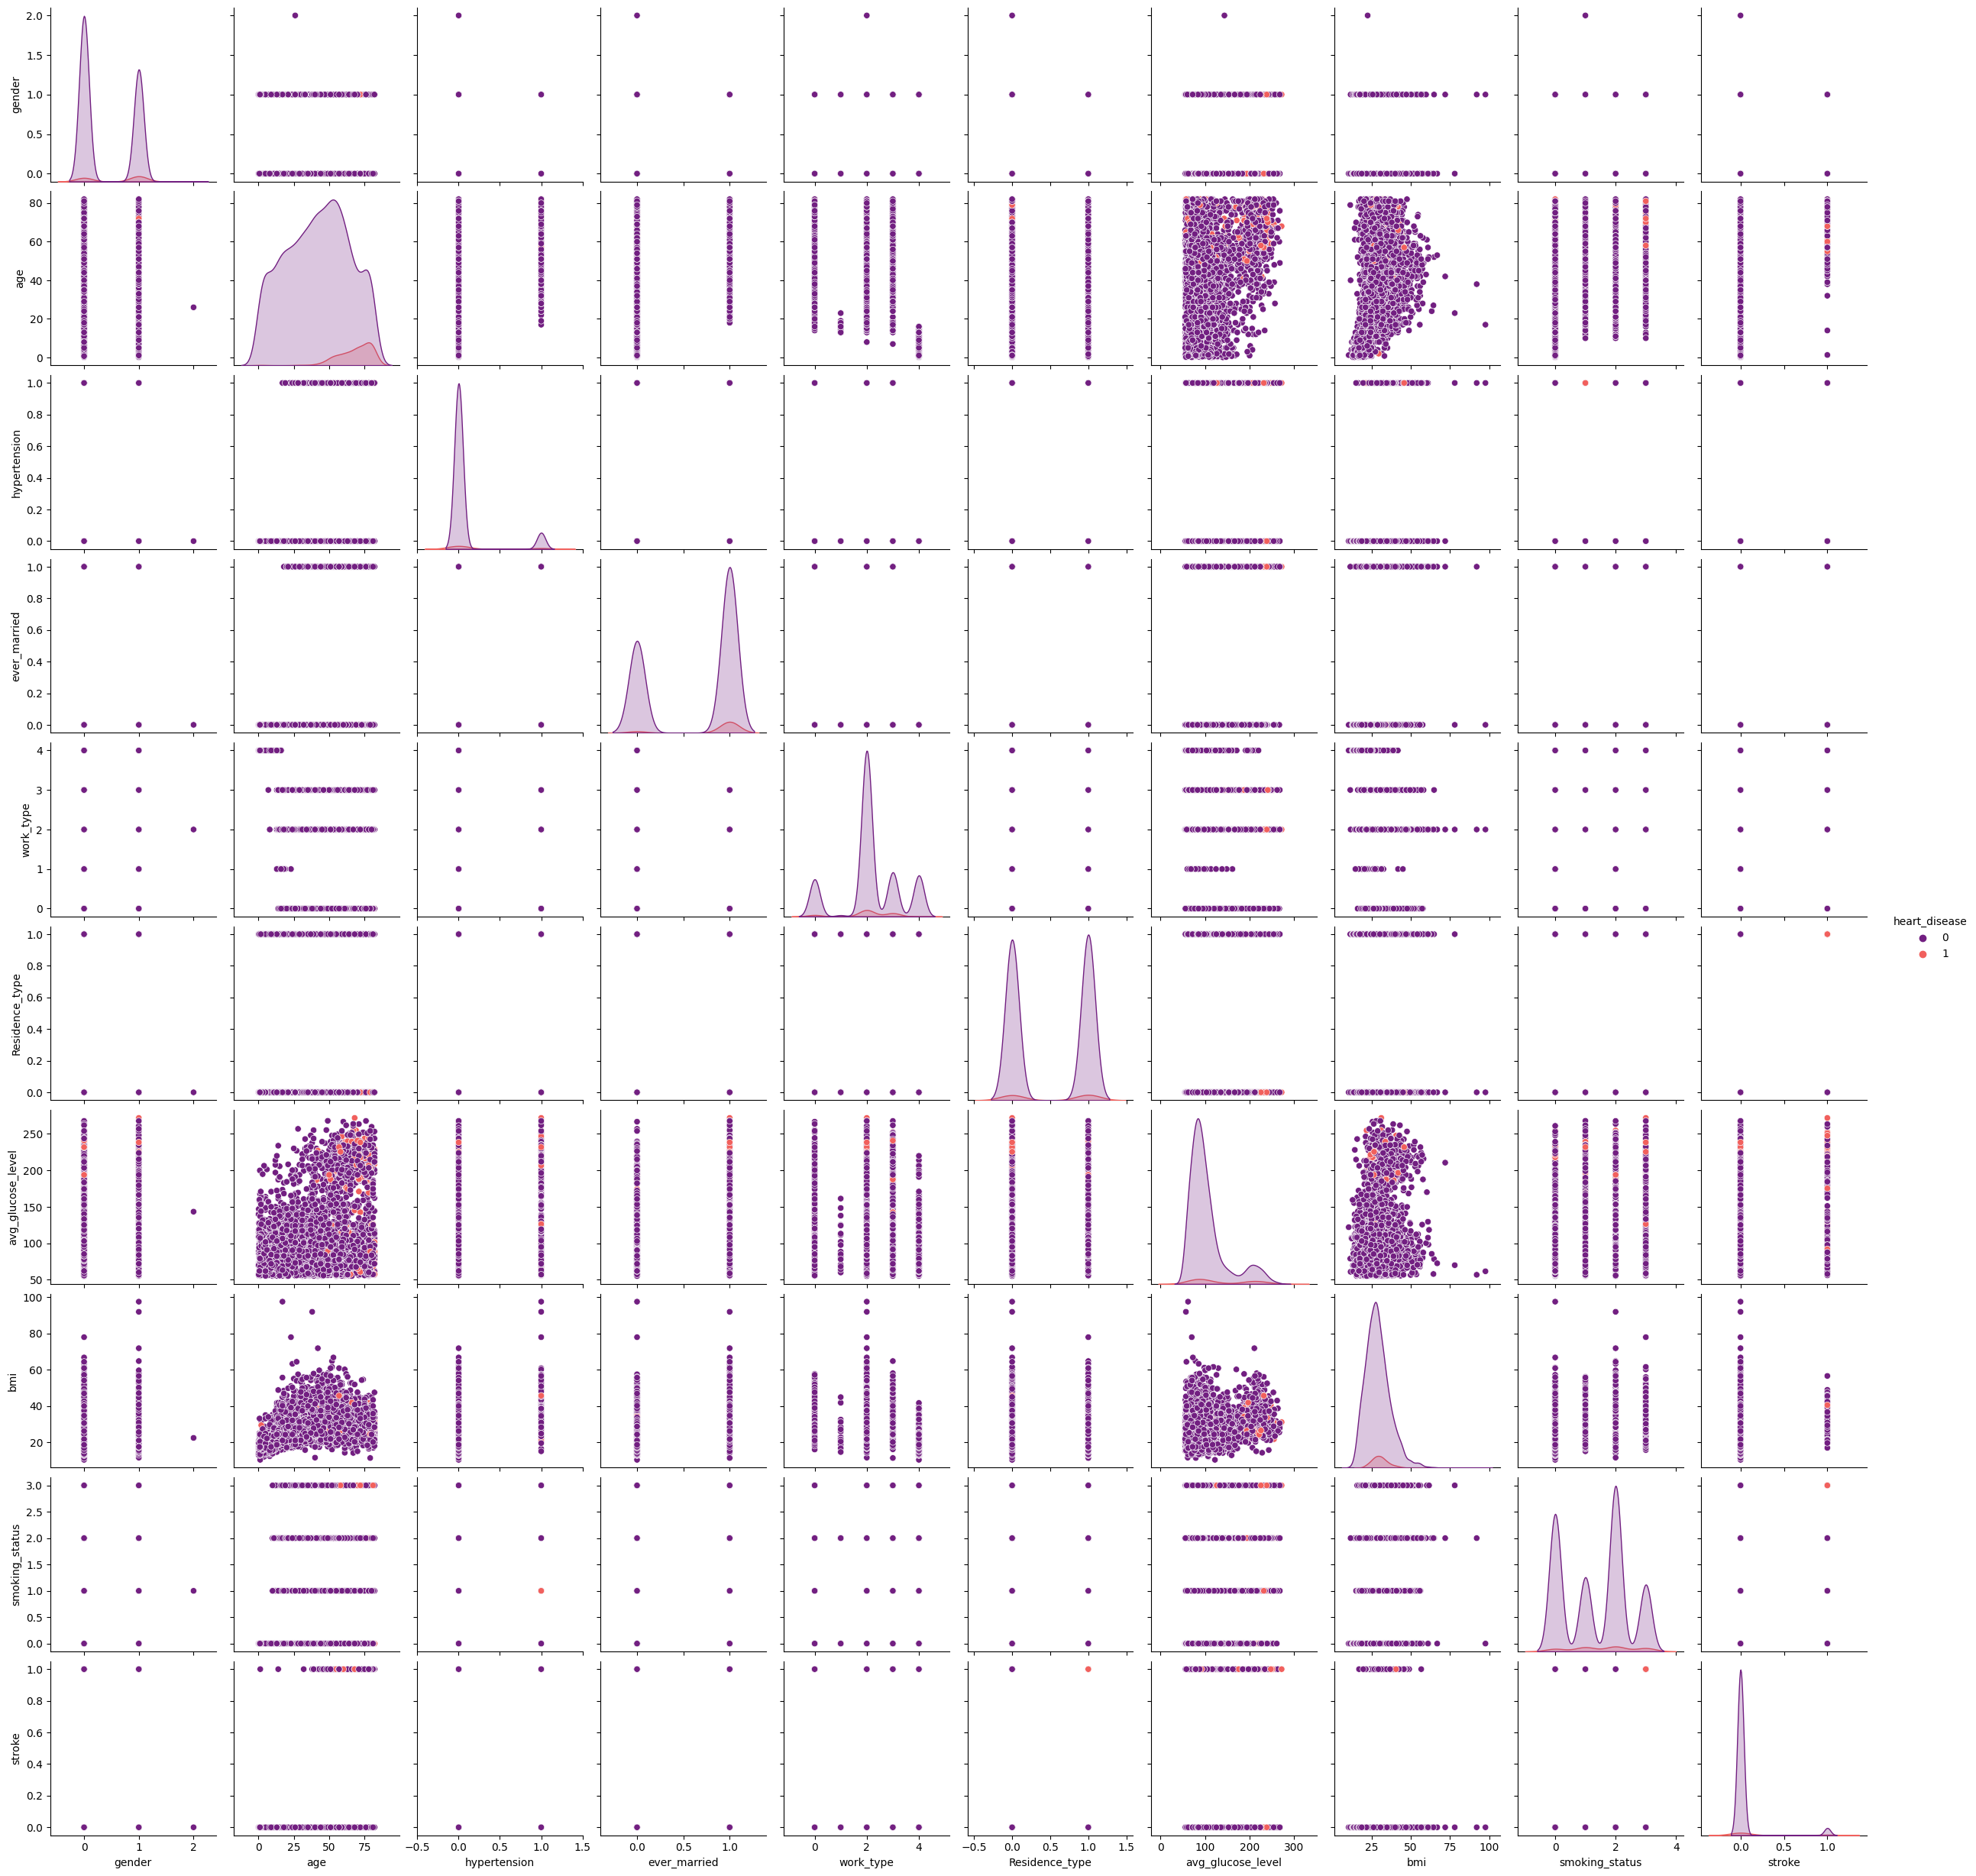

In [ ]:
# Display pair plot for data visualization
# Use iloc to remove 'id' since it's not an actual feature
sns.pairplot(df.iloc[:,1:len(df.columns)], hue='heart_disease', palette="magma")
plt.show()

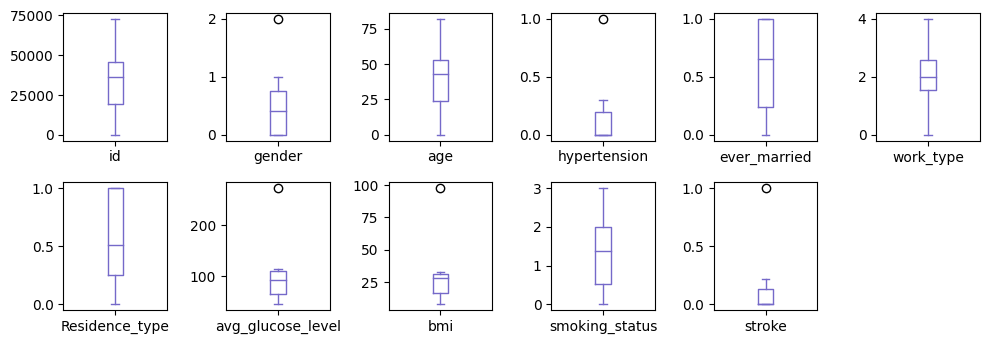

In [ ]:
description = df.describe()
# Drop the 'count' row for better visualization
description = description.drop('count')
description = description.drop('heart_disease', axis=1)
# Visual representation of data.describe()
description.plot(kind='box', subplots=True, layout=(3, 6), figsize=(10, 5), color='#7569c9')
plt.tight_layout()
plt.show()

,id,gender,age,hypertension,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,heart_disease
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,0.414286,43.226614,0.097456,0.656164,2.167710,0.508023,106.147677,28.893237,1.376908,0.048728,0.054012
std,21161.721625,0.493044,22.612647,0.296607,0.475034,1.090293,0.499985,45.283560,7.854067,1.071534,0.215320,0.226063
min,67.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000
25%,17741.250000,0.000000,25.000000,0.000000,0.000000,2.000000,0.000000,77.245000,23.500000,0.000000,0.000000,0.000000
50%,36932.000000,0.000000,45.000000,0.000000,1.000000,2.000000,1.000000,91.885000,28.100000,2.000000,0.000000,0.000000
75%,54682.000000,1.000000,61.000000,0.000000,1.000000,3.000000,1.000000,114.090000,33.100000,2.000000,0.000000,0.000000
max,72940.000000,2.000000,82.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.600000,3.000000,1.000000,1.000000


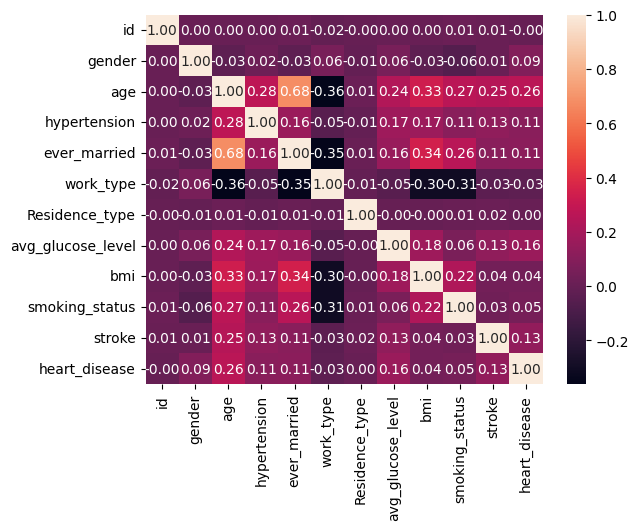

In [ ]:
# Correlation matrix to quantify relationships
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

# Summary statistics
df.describe()

In [ ]:
# Split the data into features and target variable
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Training logistic regression model
log_reg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
log_reg.fit(X_train, y_train)

# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# The penalty parameter is used to specify the norm used in the penalization: l1 or l2 regularization.
# The C parameter represents inverse of regularization strength, smaller values specify stronger regularization.
# The solver parameter specifies the algorithm to use in the optimization problem.


Confusion Matrix:
[[1928    8]
 [ 106    2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1936
           1       0.20      0.02      0.03       108

    accuracy                           0.94      2044
   macro avg       0.57      0.51      0.50      2044
weighted avg       0.91      0.94      0.92      2044



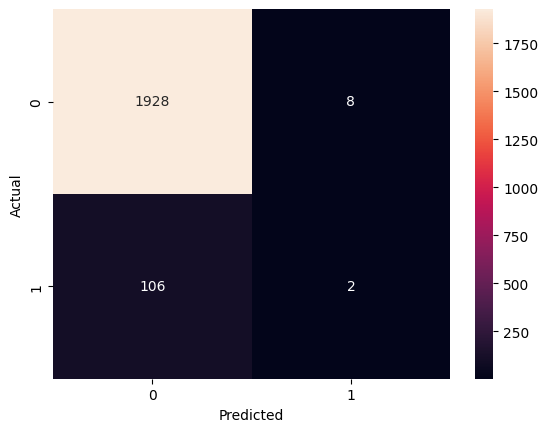

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

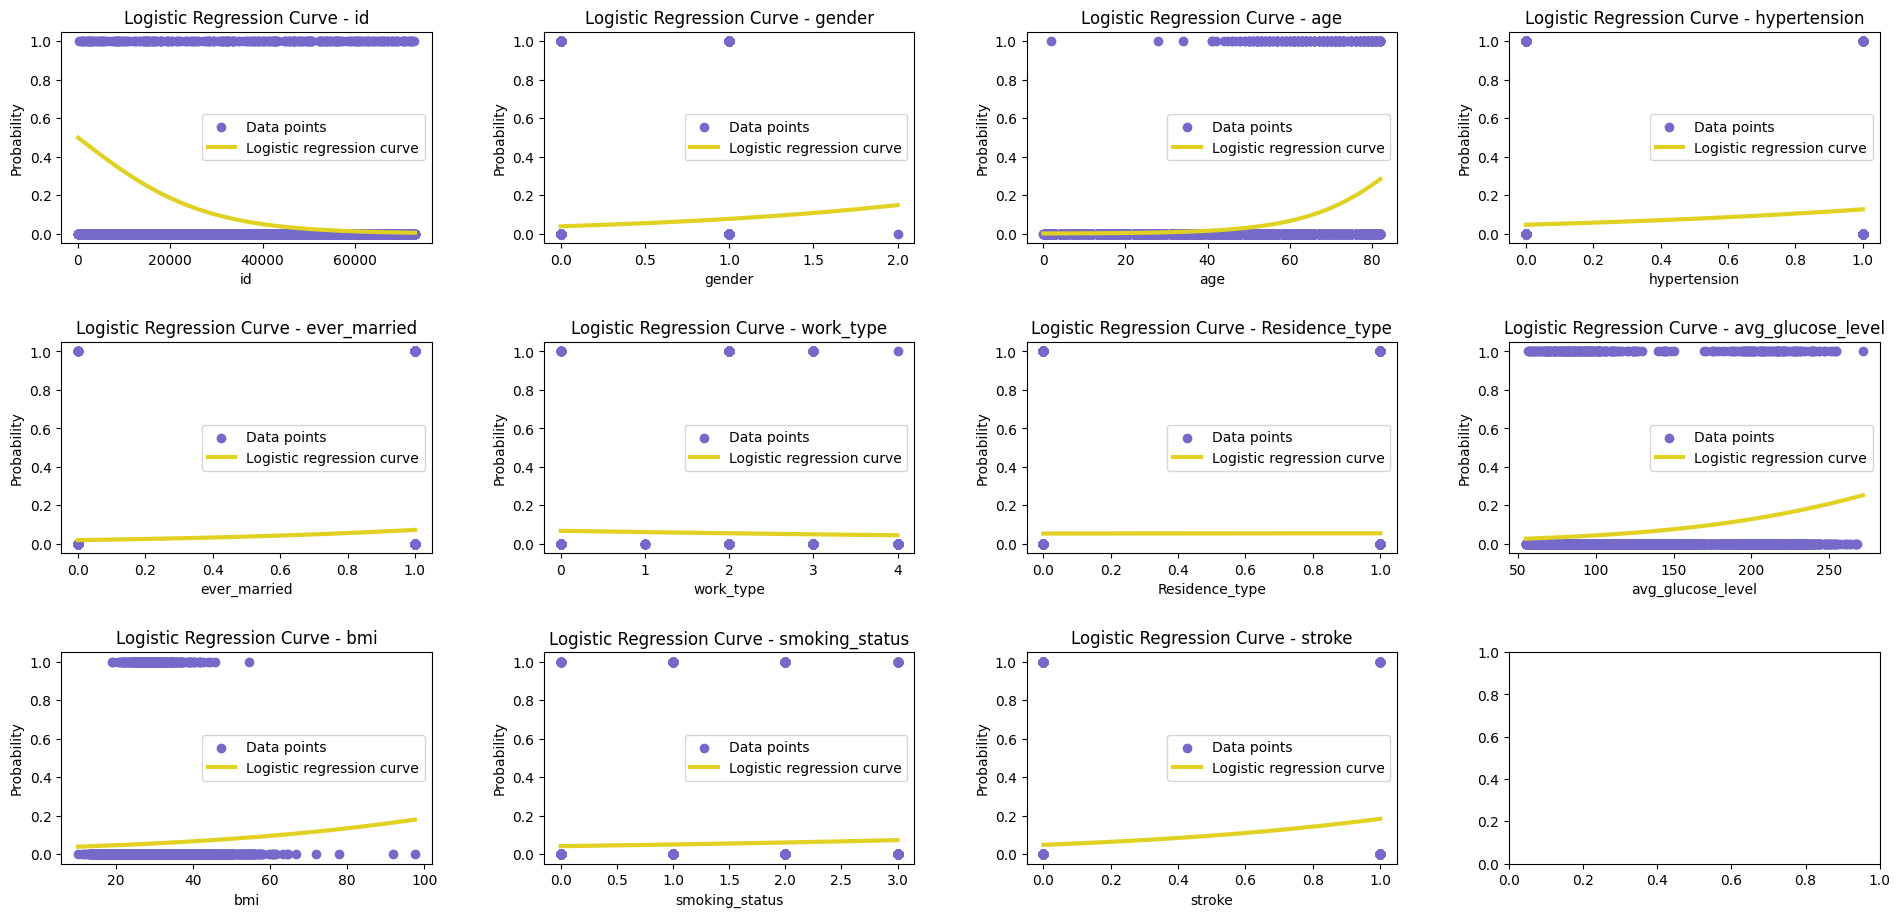

In [ ]:
# Create logistic regression object
log_reg = LogisticRegression()

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.tight_layout(pad=5.0)  # Adds padding between subplots

for i, feature in enumerate(df.columns[:-1]):  # Exclude 'Outcome' column
    row = i // 4  # Determine row index
    col = i % 4   # Determine column index

    # Reshape the feature and outcome arrays to fit the model
    X = df[[feature]]
    y = df['heart_disease']

    # Fit logistic regression model
    log_reg.fit(X, y)

    # Get min and max values of the feature for plotting
    x_test = np.linspace(X.min(), X.max(), 300)

    # Get the probability for each value in the range
    prob = log_reg.predict_proba(x_test)[:, 1]

    # Plot the data points
    axs[row, col].scatter(X, y, color='#7569c9', label='Data points')

    # Plot the sigmoid curve
    axs[row, col].plot(x_test, prob, color='#e0d122', lw=3, label='Logistic regression curve' )

    axs[row, col].set_title(f'Logistic Regression Curve - {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Probability')
    axs[row, col].legend()

plt.show()



In [ ]:
import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.159737
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          heart_disease   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5098
Method:                           MLE   Df Model:                           11
Date:                Sun, 01 Oct 2023   Pseudo R-squ.:                  0.2399
Time:                        05:47:59   Log-Likelihood:                -816.26
converged:                       True   LL-Null:                       -1073.9
Covariance Type:            nonrobust   LLR p-value:                1.708e-103
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -8.2726      0.575    -14.382      0.000      -9.400      -7.145
id      

**K Means algorithm**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)  # Setting K to 5 as an example
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

In [ ]:
# Required libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function to visualize the clustering results
def plot_clusters(x, labels, k):
    # Define colors for each cluster
    colors = ['#860991', '#d6ba2f', '#c4c1b3']
    # Loop through each cluster
    for i in range(k):
        # Filter the data points that belong to the current cluster
        filtered_label0 = x[labels == i]
        # Plot the filtered data points using the corresponding color
        plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], c=colors[i])
    # Display the plot
    plt.show()

# Choose two features for clustering and visualization
features = ['gender', 'age','hypertension', 'work_type', 'heart_disease']

# Convert the selected features from DataFrame to a NumPy array for easier processing with sklearn
data =  df[features].to_numpy()

# Standardize the data - this makes the mean 0 and standard deviation 1 for each feature
# Standardization can help the k-means algorithm perform better as it's sensitive to feature scales
st_x = StandardScaler()
data = st_x.fit_transform(data)

# Apply k-means clustering on the standardized data
# Here, we're specifying 3 clusters with a fixed random state for reproducibility
kmeans = KMeans(n_clusters=2, random_state=0)
label = kmeans.fit_predict(data)

# Visualize the clustering results using the defined function
plot_clusters(data, label, 2)

# Part 2: Patterns Within Patients with Heart Disease

In [ ]:
import pandas as pd
import numpy as np
import io

In [ ]:
from google.colab import files
imported= files.upload()

Saving Mortality Dataset.csv to Mortality Dataset.csv


In [ ]:
from pandas.io.stata import BytesIO
data_mortality= pd.read_csv(BytesIO(imported['Mortality Dataset.csv']))

Explore for outliers by within numeric (continuous) features,
 defined as being outside of 1.5 * Inter Quantile Range.

In [ ]:
list_num_columns=[]
for i in data_mortality:
  for k in data_mortality[i]:
    if k >2:
      while i not in list_num_columns:
        list_num_columns.append(i)

In [ ]:
for i in data_mortality:
  if i in list_num_columns:
    for val in data_mortality[i]:
      if val> (data_mortality.describe()[i][6]+ 1.5*(data_mortality.describe()[i][6]- data_mortality.describe()[i][4])) or val< (data_mortality.describe()[i][4]- 1.5*(data_mortality.describe()[i][6]- data_mortality.describe()[i][4])):
        print('In the column', i,'there is an outlier with a value of ',val)

In the column creatinine_phosphokinase there is an outlier with a value of  7861
In the column creatinine_phosphokinase there is an outlier with a value of  2656
In the column creatinine_phosphokinase there is an outlier with a value of  1380
In the column creatinine_phosphokinase there is an outlier with a value of  3964
In the column creatinine_phosphokinase there is an outlier with a value of  7702
In the column creatinine_phosphokinase there is an outlier with a value of  5882
In the column creatinine_phosphokinase there is an outlier with a value of  5209
In the column creatinine_phosphokinase there is an outlier with a value of  1876
In the column creatinine_phosphokinase there is an outlier with a value of  1808
In the column creatinine_phosphokinase there is an outlier with a value of  4540
In the column creatinine_phosphokinase there is an outlier with a value of  1548
In the column creatinine_phosphokinase there is an outlier with a value of  1610
In the column creatinine_pho

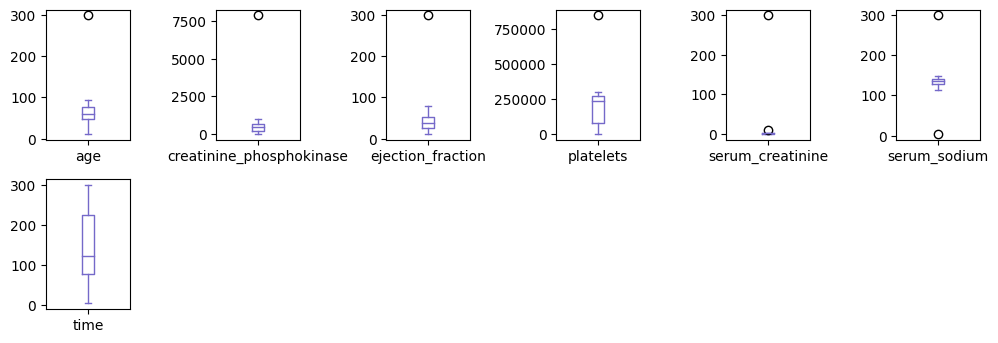

In [ ]:
import matplotlib.pyplot as plt
description= data_mortality.describe()[list_num_columns]
description.plot(kind='box', subplots=True, layout=(3,6), figsize=(10, 5), color='#7569c9')
plt.tight_layout()
plt.show()

Explore correlations between features:

In [ ]:
import seaborn as sns

<Axes: >

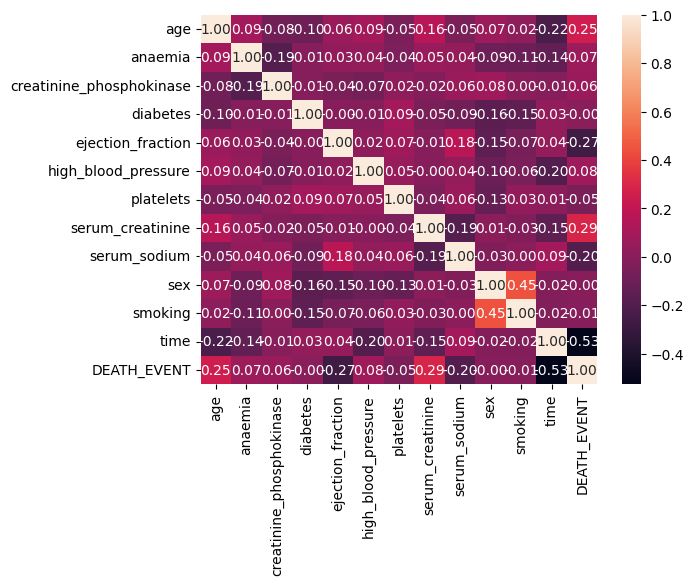

In [ ]:
corr_matrix = data_mortality.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

No strong correlations observed.

Check for Missing Values:

In [ ]:
print(data_mortality.isnull().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
def plot_clusters(x, labels, k):
  colors = ['purple','orange','green']
  for i in range(k):
    filtered_label0 = x[labels == i]
    plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], c=colors[i])
  plt.show()

In [ ]:
features_reduced= data_mortality[['ejection_fraction','time','platelets']]

In [ ]:
data =  features_reduced.to_numpy()

In [ ]:
st_x = StandardScaler()
data = st_x.fit_transform(data)

Find optimal k:

In [ ]:
sse = []
k_val=[]
for k in range(1, 30):
  kmeans = KMeans(n_clusters = k, max_iter=600)
  kmeans.fit(data)
  pred_clusters = kmeans.predict(data)
  k_val.append(k)
  sse.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
k_val= np.array(k_val)
sse= np.array(sse)

In [ ]:
k_sse= pd.DataFrame(k_val,columns=['k_val'])
k_sse['cost']=sse

Text(0.5, 1.0, 'K Value vs. Squared Error')

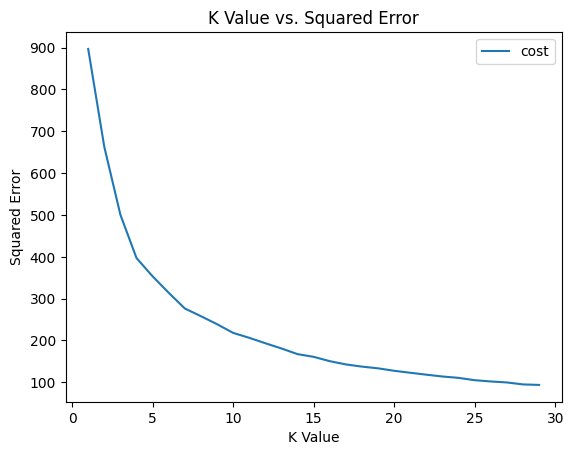

In [ ]:
k_sse.plot.line(x='k_val',y='cost')
plt.xlabel('K Value')
plt.ylabel('Squared Error')
plt.title('K Value vs. Squared Error')

In [ ]:
print(k_sse.sort_values(by='cost',ascending=True))

    k_val        cost
28     29   93.654291
27     28   94.868106
26     27   99.556232
25     26  101.912911
24     25  104.961071
23     24  110.531840
22     23  113.768510
21     22  118.129636
20     21  122.723705
19     20  127.453178
18     19  133.326816
17     18  137.438443
16     17  142.659430
15     16  150.457016
14     15  160.782707
13     14  167.257692
12     13  180.840758
11     12  193.313509
10     11  206.268659
9      10  218.057684
8       9  238.882305
7       8  257.981115
6       7  276.408798
5       6  313.968380
4       5  353.246407
3       4  396.978582
2       3  500.440825
1       2  662.723201
0       1  897.000000


Based on elbow method, optimal k is very large (>29), hence, perharps not very indicative for analysis of groupings (but does indicate that the complexity of the data does not allow an easy grouping of the data/also shows the limitation of K-means). As such, we explore the groupings k=3 for exploration purposes.

In [ ]:
kmeans = KMeans(n_clusters = 3, max_iter=600)
kmeans.fit(data)
pred_clusters = kmeans.predict(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


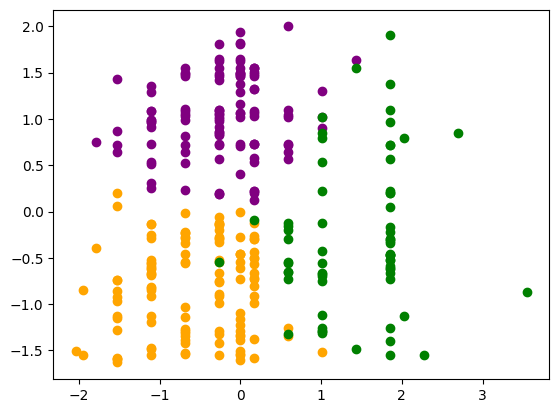

In [ ]:
plot_clusters(data, pred_clusters, k=3)

In [ ]:
data_mortality['KMeans_Clusters_3'] = pd.Series(pred_clusters, index=data_mortality.index)

In [ ]:
set(data_mortality['KMeans_Clusters_3'])

{0, 1, 2}

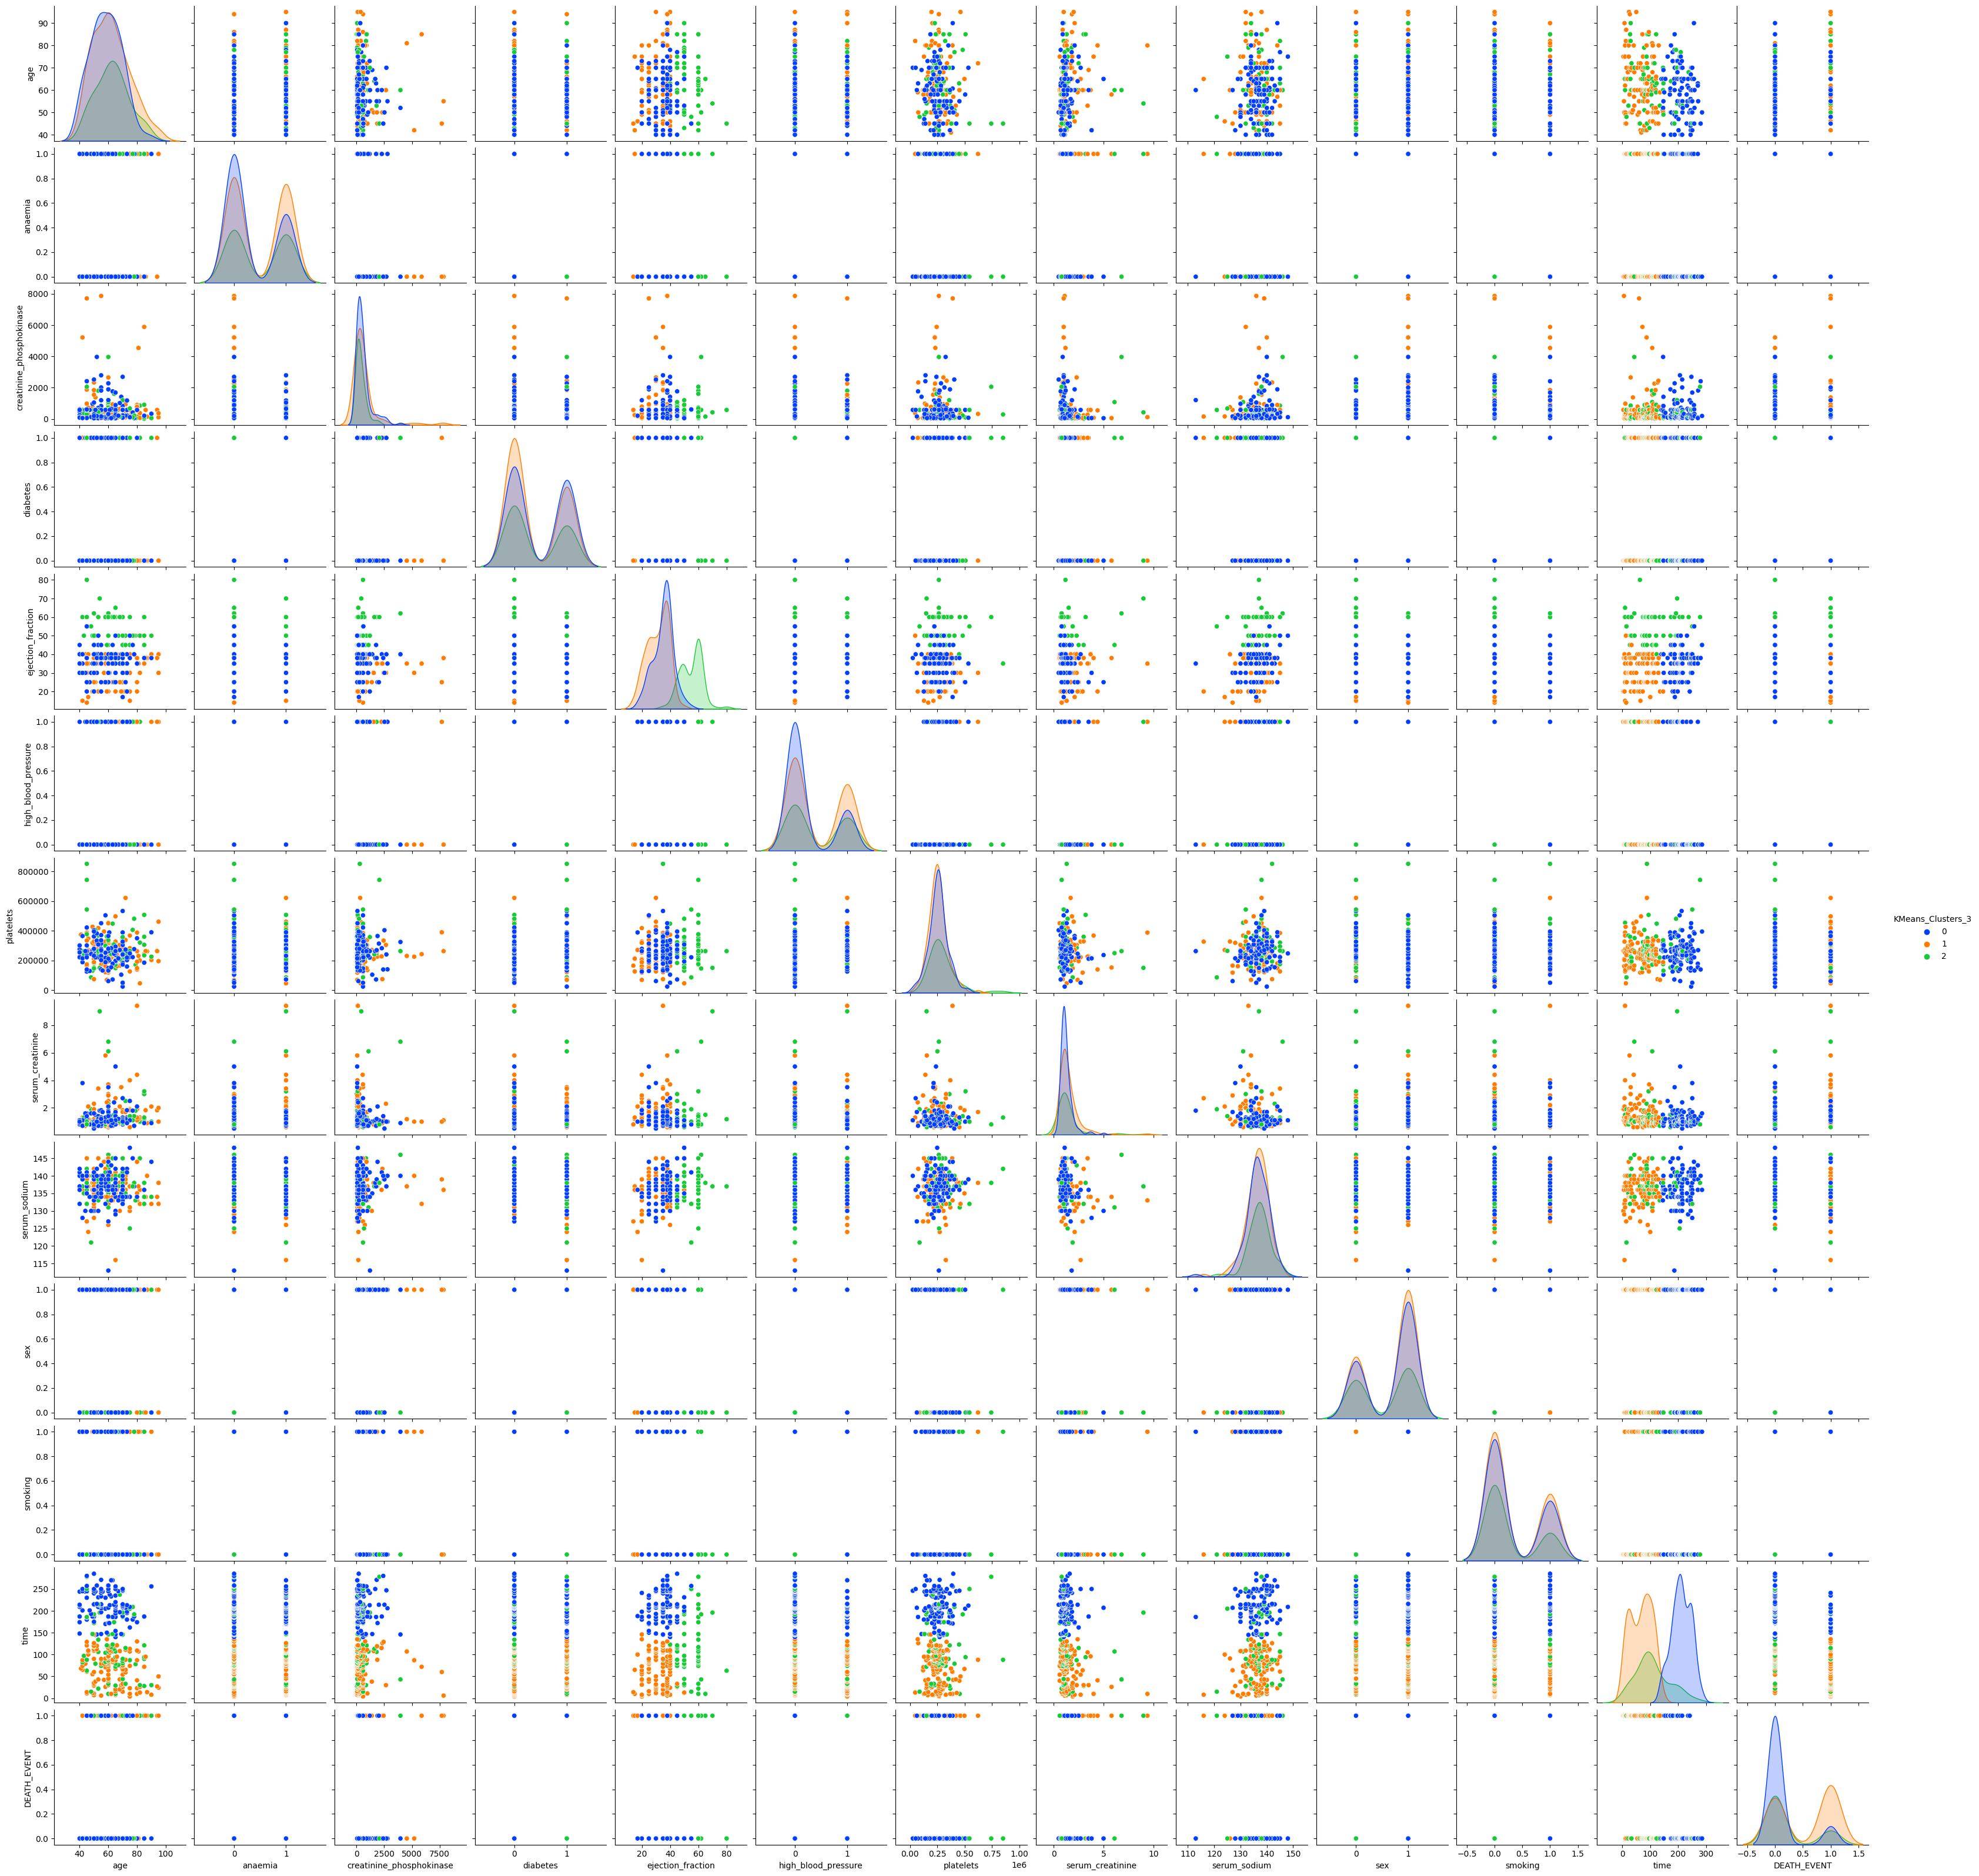

In [ ]:
sns.pairplot(data_mortality, hue='KMeans_Clusters_3', palette="bright")
plt.show()